# MBTI Prediction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("./data/mbti_1.csv", header=0)

data.head()


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
from parser import parse_data

data_parsed = parse_data(data)

data_parsed.head()

,id,type,post
0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
320975,0,INFJ,http://www.youtube.com/watch?v=ZRCEq_JFeFM
86750,0,INFJ,http://playeressence.com/wp-content/uploads/20...
329650,0,INFJ,http://discovermagazine.com/2012/jul-aug/20-th...
78075,0,INFJ,Welcome and stuff.


## Dataset Analysis

In [19]:
print("Data shape is: {0}, and has columns {1}".format(data.shape, data.columns))

type_count = data.type.value_counts()

Data shape is: (8675, 2), and has columns Index(['type', 'posts'], dtype='object')


### Distribution of types of dataset users

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64


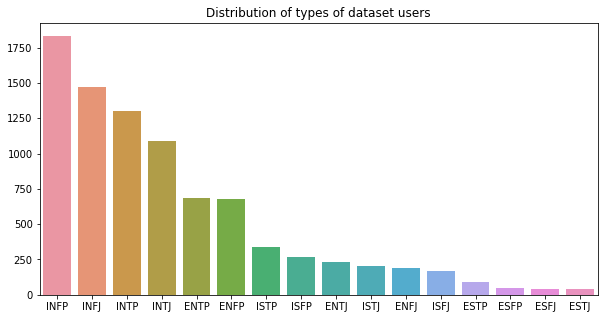

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

print(type_count)
plt.figure(figsize=(10,5))
sns.barplot(type_count.index, type_count.values)
plt.title('Distribution of types of dataset users')
plt.show()

Here we can see that the population is not equally distributed. We have almost 2000 posts from the type INFP but less than 50 on ESTJ. It may represent the population, but it means that the prediction will be much more effective for INFP than on ESTJ.

### Number of words in posts by type
It may be interesting to calculate the average number of words by type to see if there is a notable difference.
Inspired by data analysis on https://www.kaggle.com/laowingkin/mbti-study-personality

In [9]:
from parser import parse_posts

def number_words_in_post(post):
    return len(post.split())

data['number_of_words'] = data['posts'].apply(lambda posts: sum([number_words_in_post(post) for post in parse_posts(posts)])/50)

print(data.head())
print(data.groupby(data.type)["number_of_words"].mean())

   type                                              posts  id  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   0   
1  ENTP  'I'm finding the lack of me in these posts ver...   1   
2  INTP  'Good one  _____   https://www.youtube.com/wat...   2   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...   3   
4  ENTJ  'You're fired.|||That's another silly misconce...   4   

   number_of_words  
0            12.10  
1            24.38  
2            17.70  
3            22.26  
4            20.32  
type
ENFJ    26.688421
ENFP    26.160326
ENTJ    25.312641
ENTP    25.077197
ESFJ    26.750476
ESFP    21.344167
ESTJ    25.551795
ESTP    24.203820
INFJ    26.526925
INFP    25.848035
INTJ    24.831659
INTP    24.904709
ISFJ    25.783012
ISFP    23.664797
ISTJ    25.204585
ISTP    24.267240
Name: number_of_words, dtype: float64


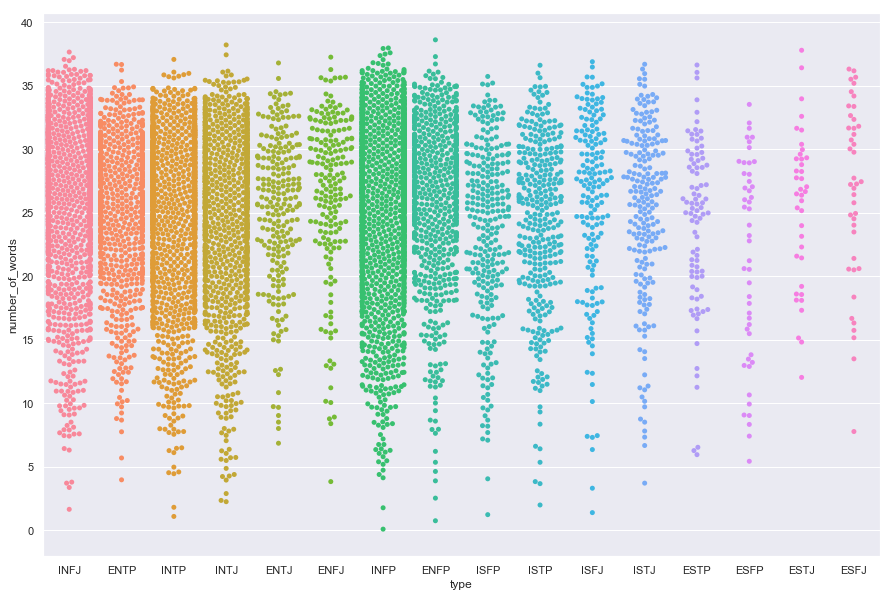

In [63]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "number_of_words", data=data)

### Vocabulary by type
Here we will analyze the vocabulary used by types of user and see if there is a trend.

In [18]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
  
lemmatizer = nltk.WordNetLemmatizer()
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

def get_vocab(post):
    words = tokenizer.tokenize(post)
    words = [word.lower() for word in words]
    stop_words = set(nltk.corpus.stopwords.words('english')) 
    filtered_sentence = [w for w in words if not w in stop_words]
    lemms = [lemmatizer.lemmatize(word) for word in filtered_sentence]
    return nltk.FreqDist(lemms)


types = data.type.unique()
def get_vocab_type(data):
    for type in types:
        posts = ""
        post = data.loc[data['type'] == type, :]['posts']
        posts = [p for p in post]
        long_post = ". ".join(posts)
        most_common = [word[0] for word in get_vocab(long_post).most_common(10)]
        print("Most common words for type {0} are {1}".format(type, most_common))
        


# print(get_vocab(data.posts[1]).most_common(10))
get_vocab_type(data)

[nltk_data] Downloading package punkt to /Users/cecile/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cecile/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/cecile/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Most common words for type INFJ are ['like', 'think', 'people', 'know', 'one', 'infj', 'really', 'thing', 'time', 'would']
Most common words for type ENTP are ['like', 'think', 'people', 'one', 'entp', 'know', 'get', 'would', 'thing', 'really']
Most common words for type INTP are ['like', 'think', 'people', 'one', 'would', 'know', 'intp', 'thing', 'time', 'get']
Most common words for type INTJ are ['like', 'people', 'think', 'one', 'intj', 'would', 'know', 'time', 'thing', 'get']
Most common words for type ENTJ are ['like', 'think', 'people', 'one', 'entj', 'would', 'get', 'know', 'thing', 'type']
Most common words for type ENFJ are ['like', 'think', 'people', 'know', 'really', 'enfj', 'one', 'thing', 'get', 'would']
Most common words for type INFP are ['like', 'think', 'people', 'really', 'one', 'know', 'thing', 'time', 'infp', 'feel']
Most common words for type ENFP are ['like', 'think', 'people', 'enfp', 'know', 'one', 'really', 'thing', 'get', 'time']
Most common words for type ISF

## Learning

In [30]:
print("Kaggle data size : {}".format(data.shape))
# print(posts.iloc[6376])
print("Parsed Kaggle data size : {}".format(data_parsed.shape))

class_names = data_parsed.type.unique()
print("Labels : {}".format(class_names))


Kaggle data size : (8675, 3)
Parsed Kaggle data size : (422845, 3)
Labels : ['INFJ' 'ENTP' 'INTP' 'INTJ' 'ENTJ' 'ENFJ' 'INFP' 'ENFP' 'ISFP' 'ISTP'
 'ISFJ' 'ISTJ' 'ESTP' 'ESFP' 'ESTJ' 'ESFJ']


### Tackle imbalanced data issue

As seen in the dataset analysis, our dataset is imbalanced which means our classes are not represented equally. This leads to the accuracy paradox where the accuracy is only reflecting the underlying class distribution. There are several tactics to handle imbalanced data and we are going to try some out.

In [5]:
from resampling import upsample_minority, downsample_majority

data_upsampled = upsample_minority(data_parsed)
data_downsampled = downsample_majority(data_parsed)


INFP    89796
INFJ    72105
INTP    63359
INTJ    52471
ENTP    33761
ENFP    32769
ISTP    16498
ISFP    13000
ENTJ    11273
ISTJ     9913
ENFJ     9288
ISFJ     8121
ESTP     4337
ESFP     2215
ESFJ     2018
ESTJ     1921
Name: type, dtype: int64


In [6]:
""" Choose dataset to test on """

# dataset = data
# dataset = data_parsed
# dataset = data_upsampled
dataset = data_downsampled

### Split dataset in train and test sets

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.4, random_state=0)
print(train.shape, test.shape)
train.head()

(18441, 3) (12295, 3)


,id,type,post
63871,3146,ISFP,Thank you for this post.
94230,7480,ESTJ,"My favourite is No Pain, No Gain. This is what..."
312088,8463,ISFP,I'ma go ahead and say Ti
374782,1757,ENTJ,Yes and it always works.
127945,6495,ENFP,I've been thinking maybe going to Istanbul thi...


### Preprocessing

In [8]:
from preprocessing import format_text

train = pd.DataFrame(train)
train['preprocessed_post'] = train['post'].apply(format_text)
train.head()

,id,type,post,preprocessed_post
63871,3146,ISFP,Thank you for this post.,thank you for this post
94230,7480,ESTJ,"My favourite is No Pain, No Gain. This is what...",my favourite is no pain no gain this is what i...
312088,8463,ISFP,I'ma go ahead and say Ti,i ma go ahead and say ti
374782,1757,ENTJ,Yes and it always works.,yes and it always works
127945,6495,ENFP,I've been thinking maybe going to Istanbul thi...,i ve been thinking maybe going to istanbul thi...


### Classification

#### Naive Bayesian

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

text_clf = text_clf.fit(train['preprocessed_post'], train['type'])

### Prediction

In [10]:
from preprocessing import format_text

test = pd.DataFrame(test)
test['preprocessed_post'] = test['post'].apply(format_text)
test.head()

,id,type,post,preprocessed_post
248559,5659,INFP,Regret. Shame. Inadequacy. Humiliation.,regret shame inadequacy humiliation
218149,1274,INTJ,Never had a problem with public and almost nev...,never had a problem with public and almost nev...
79234,1159,ENFP,"Falcon5 I am not sure I can help a lot, but I ...",falcon i am not sure i can help a lot but i do...
26817,792,ENTP,"Oh, we all know they mean well.",oh we all know they mean well
235295,1070,ISTP,"very true, and wyoming is trying to protect th...",very true and wyoming is trying to protect the...


In [20]:
from sklearn.metrics import precision_recall_fscore_support

predicted = text_clf.predict(test['preprocessed_post'])

print("Classes predicted: {}".format(np.unique( predicted )))
print("Classes in test data: {}".format(np.unique( test['type'] )))
print()


print("Accuracy: {}".format(np.mean(predicted == test['type'])))
print()

precision, recall, f_score, support = precision_recall_fscore_support(test['type'], predicted, average='weighted')  # average="micro"||"macro"||"weighted"
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F-beta score: {}".format(f_score))

# default: 0.2072
# stop_words: 0.2069
# stop_words & preprocessed: 0.2069
# + parsed & upsample: 0.4459
# + parsed & downsample: 0.1953

Classes predicted: ['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']
Classes in test data: ['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']

Accuracy: 0.1952826352175681

Precision: 0.19129490444934918
Recall: 0.1952826352175681
F-beta score: 0.18448219290268295


#### Confusion Matrix

Confusion matrix, without normalization
[[177  40  43  21  97  27  24  37  65  43  15  19  43  39  44  21]
 [ 78 107  40  47 104  57  21  39  66  33  18  12  49  41  53  15]
 [ 62  39 137  36  86  32  32  45  46  21  49  24  27  40  59  15]
 [ 60  49  53  79  95  44  27  43  71  37  32  34  37  25  52  28]
 [ 45  32  31  21 440  15   7  24  32  13  10   9  23  24  40   8]
 [ 43  33  34  25  80 245  15  38  51  15  21  13  23  55  41  18]
 [ 65  58  45  36  82  43 145  44  60  27  25  20  30  42  49  21]
 [ 51  30  37  19  76  26  20 234  48  15  17  17  37  55  58  17]
 [ 76  50  39  27  85  49  25  47 108  30  24  25  57  52  38  11]
 [ 83  45  34  36  94  40  30  41  88  58  24  21  40  64  58  14]
 [ 68  41  55  46  71  45  37  44  81  35  56  37  33  42  56  21]
 [ 59  27  63  47  90  40  36  47  54  27  51  65  44  51  52  23]
 [ 61  45  33  18 103  43  18  32  59  28  21  23 170  55  48  18]
 [ 59  35  33  33  88  48  22  45  61  45  13  29  51 148  59  23]
 [ 62  39  41  28  72 

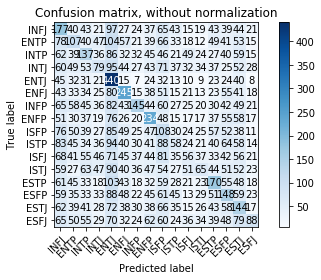

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from performance import plot_confusion_matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(test['type'], predicted, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plot_confusion_matrix(test['type'], predicted, classes=class_names, normalize=True,
                      # title='Normalized confusion matrix')

plt.show()

#### Cross Validation

In [40]:
from sklearn.model_selection import cross_validate

np.random.seed(1)

scoring = {'acc': 'accuracy',
           'f1_micro': 'f1_micro'}

results = cross_validate(text_clf, train['preprocessed_posts'], train['type'], cv=5, 
                          scoring=scoring, n_jobs=-1)

In [41]:
# print(results)
print("Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_acc']),
                                                          np.std(results['test_acc'])))

print("F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_f1_micro']),
                                                          np.std(results['test_f1_micro'])))


# Accuracy: 0.2140 (+/- 0.0004)
# F1: 0.2140 (+/- 0.0004)

# Preprocessed
# Accuracy: 0.2144 (+/- 0.0006)
# F1: 0.2144 (+/- 0.0006)

Accuracy: 0.2144 (+/- 0.0006)
F1: 0.2144 (+/- 0.0006)


#### SVM

In [22]:
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(max_iter=1000, tol=1e-3)),
                    ])

text_clf_svm = text_clf_svm.fit(train['preprocessed_post'], train['type'])

predicted_svm = text_clf_svm.predict(test['preprocessed_post'])


print("Classes predicted: {}".format(np.unique( predicted_svm )))
print("Classes in test data: {}".format(np.unique( test['type'] )))
print()


print("Accuracy: {}".format(np.mean(predicted_svm == test['type'])))
print()

precision_svm, recall_svm, f_score_svm, support_svm = precision_recall_fscore_support(test['type'], predicted_svm, average='weighted')  # average="micro"||"macro"||"weighted"
print("Precision: {}".format(precision_svm))
print("Recall: {}".format(recall_svm))
print("F-beta score: {}".format(f_score_svm))

# default : 0.6585
# stop_words : 0.6571
# stop_words & preprocessed: 0.6591

Classes predicted: ['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']
Classes in test data: ['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']

Accuracy: 0.20374135827572185

Precision: 0.19145228775050147
Recall: 0.20374135827572185
F-beta score: 0.19405997665688643


Confusion matrix, without normalization
[[  194   293    72   245    30    27    30    37   608  1038   286   494
     69    89    75   123]
 [  222  1977   197   878    63    76    57   124  1890  3615  1167  1728
    176   304   273   415]
 [   66   297   252   304    18    26    28    40   572  1050   532   750
     66   117   104   163]
 [  180   944   273  1732    81    74    91   130  1768  3133  1302  2486
    181   319   261   439]
 [   16    61    16    42    52     7     6    10   112   201    62   125
     18    26    12    25]
 [   11    89    20    75     6    32     4    16   133   225    76   134
     21    21     9    31]
 [   15    49    20    52     4     5    42     4   101   212    79   116
      6    23    15    30]
 [   26   117    34   151    12    17    11    76   238   411   145   279
     30    65    30    59]
 [  375  1805   446  1597   123   156   106   232  7265  8057  2287  3891
    380   683   497   803]
 [  463  2308   485  1865   155   214   132   248  

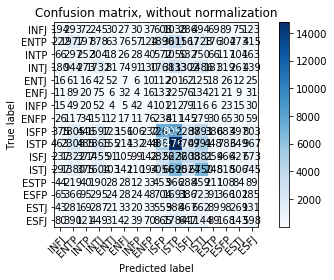

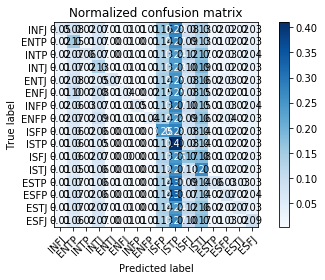

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from performance import plot_confusion_matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(test['type'], predicted_svm, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(test['type'], predicted_svm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()